# EasyTS example 1a: low resolution analysis with power-2 limb darkening
**Author:** Hannu Parviainen <br>
**Edited:** 24 May 2024

This notebook gives a first introduction into transmission spectroscopy with EasyTS and shows how reproduce a low-resolution version of the transmission spectroscopy analysis of WASP-39b observed with JWST NIRISS by [Feinstein et al (2023)](https://ui.adsabs.harvard.edu/abs/2023Natur.614..670F/abstract). Later notebooks show how to use the LDTk-based limb darkening model and what happens when we increase the resolution.

We start by forcing different multithreaded codes to use a single thread. This is important when parallelising the computations with multiprocessing, since it would be very easy to end up with a number of processes all trying to use all the cores in the computer. After this, we initialise matplotlib and import some standard packages and functions.

In [1]:
%run ../setup_multiprocessing.py

In [2]:
%matplotlib inline

In [5]:
from multiprocessing import Pool
from xarray import load_dataset
from matplotlib.pyplot import subplots, setp

from easyts import EasyTS, TSData

## Read in the data

We read the spectroscopic light curves and store them as `easyts.TSData` objects. `TSData` is an utility class to store and manipulate  spectroscopic time series before using them in a transmission spectrum analysis.

**None:** [appendix 1](appendix_1_data_preparation.ipynb) notebook shows how the original [Feinstein et al (2023)](https://ui.adsabs.harvard.edu/abs/2023Natur.614..670F/abstract) light curves downloaded from Zotero are converted into a simple xarray dataset.

We first define a simple utility function to read the xarray DataSet into `TSData` and then read the order 1 light curves. We remove any strong individual outlier points, and plot the data.

In [6]:
def read_data(fname):
    with load_dataset(fname) as ds:
        return TSData(time=ds.time.values, wavelength=ds.wavelength.values, fluxes=ds.flux.values, errors=ds.error.values)

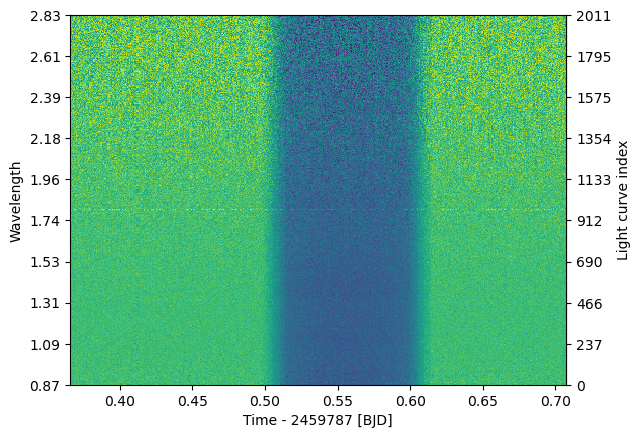

In [11]:
d1 = read_data('data/nirHiss_order_1.h5')
d1.remove_outliers()
d1.plot();

Next, we read order 2 light curves, crop the spectral range not to overlap with order 1, and again remove any strong outliers.

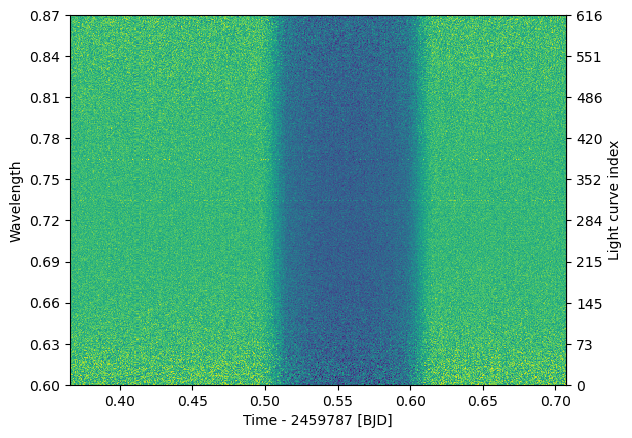

In [12]:
d2 = read_data('data/nirHiss_order_2.h5')
d2.crop_wavelength(0.6, d1.wllims[0])
d2.remove_outliers()
d2.plot();

Finally, we bin the spectroscopic light curves to R=100 (we are doing a low-resolution analysis in this notebook anyway) and combine the two orders into a single `TSData` object.

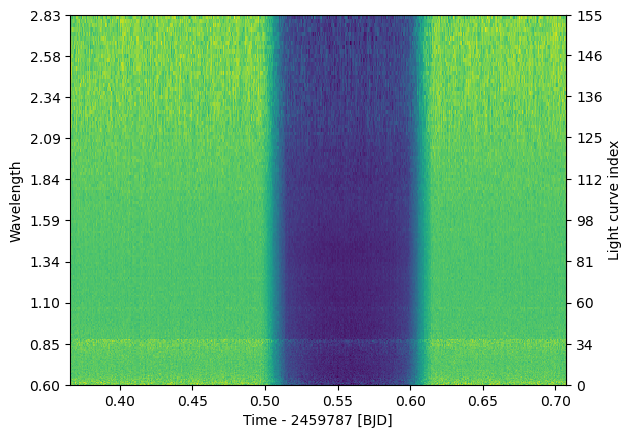

In [14]:
db = d2.bin_wavelength(r = 100) + d1.bin_wavelength(r = 100)
ax = db.plot()

### Initialize EasyTS and set the priors

In [11]:
ts = EasyTS('01a_lowres_power2', 'power-2', 
            db.wavelength, db.time, db.fluxes, db.errors, 
            nk=50, nbl=20, nldc=10, nthreads=1)

We can take a look at the transmission spectum model parameterization using `EasyTS.ps`, where `ps` stands for "parameter set". Let's print the first 10 parameters (feel free to print them all to see the full parameterization).

In [12]:
ts.ps[:10]

[  0 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   1 |G| tc             N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   2 |G| p              N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   4 |G| secw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   5 |G| sesw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   6 |G| ldc1_00        U(a = 0, b = 1)                          [    -inf ..      inf],
   7 |G| ldc2_00        U(a = 0, b = 1)                          [    -inf ..      inf],
   8 |G| ldc1_01        U(a = 0, b = 1)                          [    -inf ..      inf],
   9 |G| ldc2_01        U(a = 0, b = 1)                          [    -inf ..      inf]]

The first thing we need to do at the beginning of the analysis is to set priors for the transit center (`tc`) and orbital period (`p`). The stellar density (`rho`) and the impact parameter (`b`) are usually constrained well by our photometry, so we can leave the default uninformative priors. 

In [13]:
ts.set_prior('tc', 'NP', 2459694.285977, 0.003)
ts.set_prior('p', 'NP', 4.0548695469509, 1e-5)

In [14]:
ts.ps[:10]

[  0 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   1 |G| tc             N(μ = 2459694.285977, σ = 0.003)         [    -inf ..      inf],
   2 |G| p              N(μ = 4.0548695469509, σ = 1e-05)        [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   4 |G| secw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   5 |G| sesw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   6 |G| ldc1_00        U(a = 0, b = 1)                          [    -inf ..      inf],
   7 |G| ldc2_00        U(a = 0, b = 1)                          [    -inf ..      inf],
   8 |G| ldc1_01        U(a = 0, b = 1)                          [    -inf ..      inf],
   9 |G| ldc2_01        U(a = 0, b = 1)                          [    -inf ..      inf]]

Next, we can set a slightly less uninformative priors on the radius ratios by using the `EasyTS.set_radius_ratio_prior` method. Let's take a look at the first four radius ratio parameters

In [15]:
ts.ps[24:30]

[ 24 |G| ldc1_09        U(a = 0, b = 1)                          [    -inf ..      inf],
  25 |G| ldc2_09        U(a = 0, b = 1)                          [    -inf ..      inf],
  26 |G| k_001          U(a = 0.02, b = 0.2)                     [    0.00 ..      inf],
  27 |G| k_002          U(a = 0.02, b = 0.2)                     [    0.00 ..      inf],
  28 |G| k_003          U(a = 0.02, b = 0.2)                     [    0.00 ..      inf],
  29 |G| k_004          U(a = 0.02, b = 0.2)                     [    0.00 ..      inf]]

In [16]:
ts.set_radius_ratio_prior('UP', 0.14, 0.15)

In [17]:
ts.ps[24:30]

[ 24 |G| ldc1_09        U(a = 0, b = 1)                          [    -inf ..      inf],
  25 |G| ldc2_09        U(a = 0, b = 1)                          [    -inf ..      inf],
  26 |G| k_001          U(a = 0.14, b = 0.15)                    [    0.00 ..      inf],
  27 |G| k_002          U(a = 0.14, b = 0.15)                    [    0.00 ..      inf],
  28 |G| k_003          U(a = 0.14, b = 0.15)                    [    0.00 ..      inf],
  29 |G| k_004          U(a = 0.14, b = 0.15)                    [    0.00 ..      inf]]

### Set the limb darkening priors

This example uses the power-2 limb darkening model with two limb darkening coefficients per limb darkening knot. Calling `EasyTS.set_ldtk_priors` calculates the priors for the limb darkening coefficients using `LDTk` automatically. 

Let's first take a look at the limb darkening coefficient priors for the first two knots before we set the priors:

In [18]:
ts.ps[6:10]

[  6 |G| ldc1_00        U(a = 0, b = 1)                          [    -inf ..      inf],
   7 |G| ldc2_00        U(a = 0, b = 1)                          [    -inf ..      inf],
   8 |G| ldc1_01        U(a = 0, b = 1)                          [    -inf ..      inf],
   9 |G| ldc2_01        U(a = 0, b = 1)                          [    -inf ..      inf]]

The default prior for the coeffients is a uniform distribution from 0 to 1. Then, lets let's use `LDTk` to calculate the priors

In [19]:
ts.set_ldtk_prior(teff=(5327, 139), logg=(4.38, 0.09), metal=(-0.01, 0.1), uncertainty_multiplier=10)

And let's look at the priors now

In [20]:
ts.ps[6:10]

[  6 |G| ldc1_00        N(μ = 0.734, σ = 0.018)                  [    -inf ..      inf],
   7 |G| ldc2_00        N(μ = 0.814, σ = 0.031)                  [    -inf ..      inf],
   8 |G| ldc1_01        N(μ = 0.596, σ = 0.015)                  [    -inf ..      inf],
   9 |G| ldc2_01        N(μ = 0.697, σ = 0.026)                  [    -inf ..      inf]]

The `uncertainty_multiplier` parameter is used to inflate the prior uncertainties. The main reason to do this is to make sure we err on the cautious side what comes to how much we trust the stellar models the limb darkening coefficient priors are based to.

### Customize the radius ratio knot locations

`EasyTS` uses a linear spacing between the radius ratio knots by default. Let's change to use geomspace and add some extra knots to cover the K line.

In [21]:
kx1 = geomspace(*ts.wavelength[[0, -1]], 45)
kx2 = linspace(0.768-0.015, 0.768+0.015, 5)
ts.set_k_knots(concatenate([kx1, kx2]))

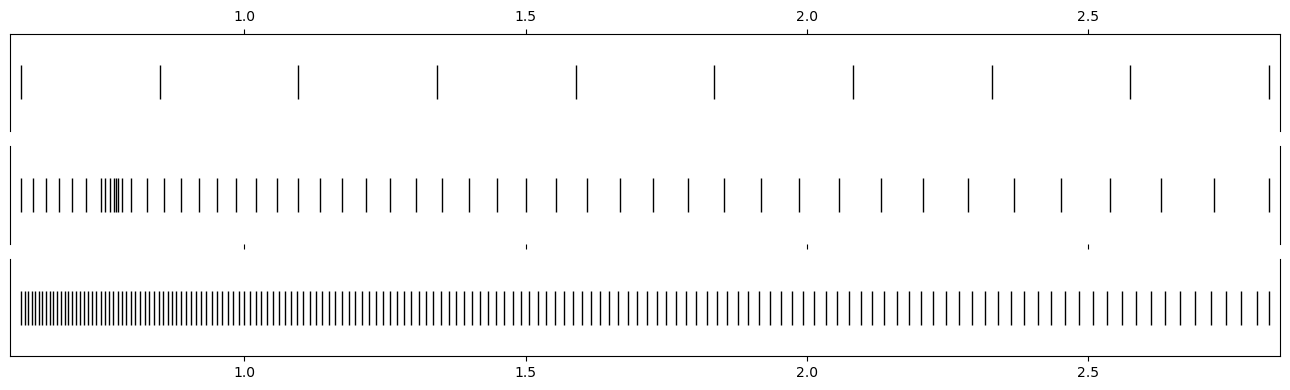

In [22]:
import seaborn as sb
fig, axs = subplots(3, 1, figsize=(13,4), sharex='all', sharey='all')
axs[2].plot(ts.wavelength, ones_like(ts.wavelength), '|k', ms=25)
axs[1].plot(ts._tsa.kx_knots, ones_like(ts._tsa.kx_knots), '|k', ms=25)
axs[0].plot(ts._tsa.ld_knots, ones_like(ts._tsa.ld_knots), '|k', ms=25)
sb.despine(ax=axs[0], top=False, bottom=True, right=False)
sb.despine(ax=axs[1], top=True, bottom=True, right=False)
sb.despine(ax=axs[2], top=True, bottom=False, right=False)
setp(axs, xlim=(ts.wavelength[0]-0.02, ts.wavelength[-1]+0.02), yticks=[])
fig.tight_layout()
#plot(ts._tsa.bx_knots, full(ts._tsa.bx_knots.size, 4), '|k')

## Fit the white light curve

In [23]:
ts.fit_white()

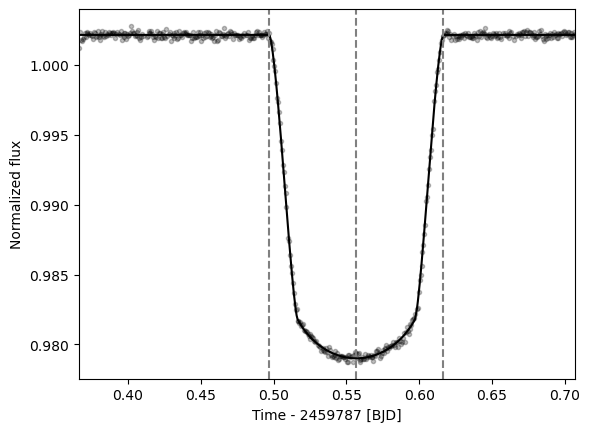

In [24]:
ax = ts.plot_white()

## Normalize the baseline

In [25]:
ts.normalize_baseline()

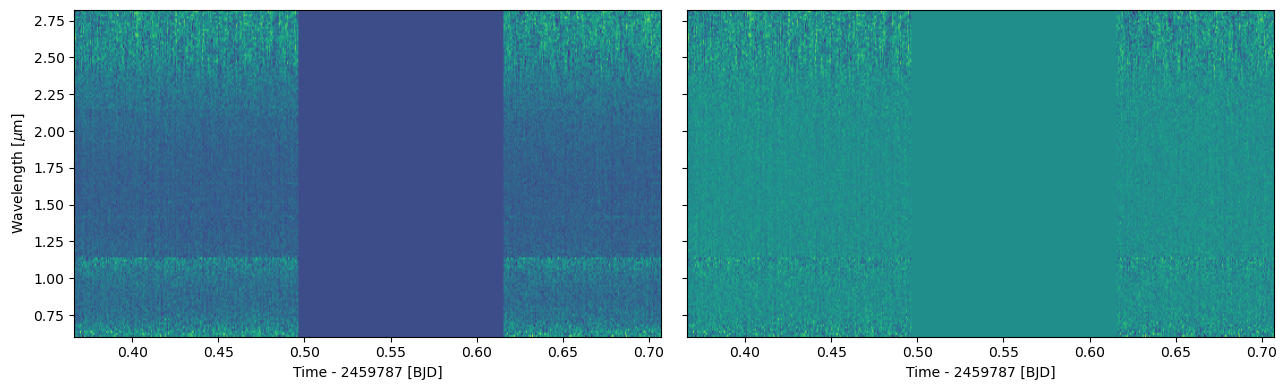

In [26]:
ts.plot_baseline();

### Set up multiprocessing

In [27]:
def lnpostf(pv):
    return squeeze(ts._tsa.lnposterior(pv))

In [28]:
pool = Pool(8)

### Global minimization

Global optimisation:   0%|          | 0/2500 [00:00<?, ?it/s]

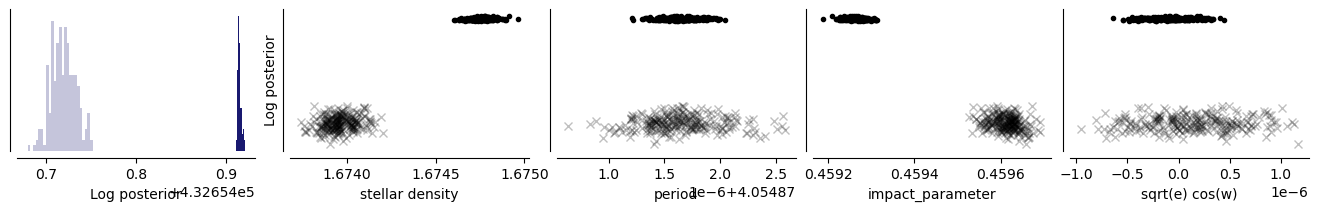

In [33]:
ts.fit(niter=2500, npop=250, pool=pool, lnpost=lnpostf)

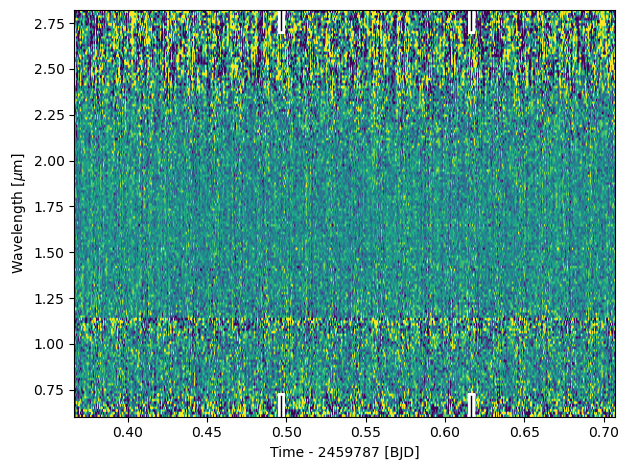

In [34]:
ax = ts.plot_residuals(pmin=5, pmax=95)

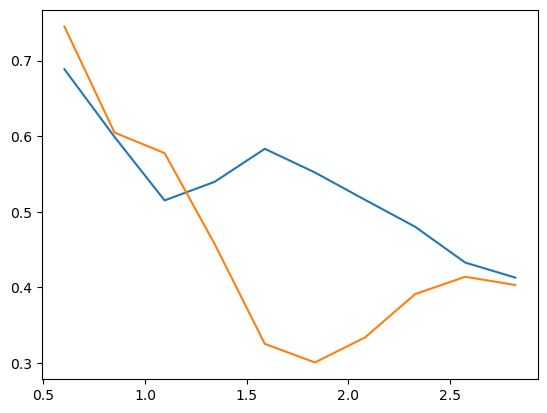

In [35]:
pv = ts._tsa.de.minimum_location
plot(ts._tsa.ld_knots, pv[ts._tsa._sl_ld][0::2])
plot(ts._tsa.ld_knots, pv[ts._tsa._sl_ld][1::2])

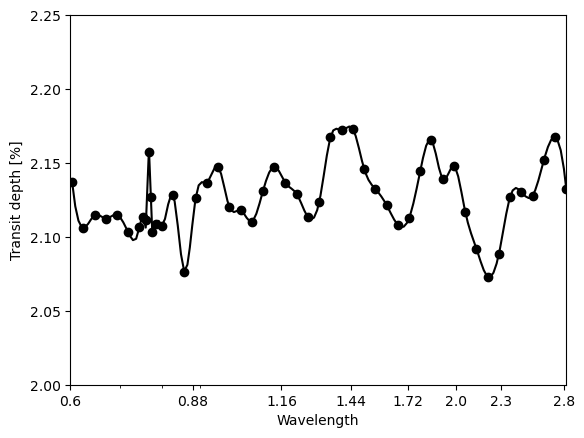

In [36]:
ax = ts.plot_transmission_spectrum()
ax.set_xscale('log')
setp(ax, ylim=(2.0, 2.25))
xticks = [0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]
ax.set_xticks(xticks, labels=xticks);

### MCMC sampling 

In [48]:
ts.set_ldtk_prior(teff=(5327, 139), logg=(4.38, 0.09), metal=(-0.01, 0.1), uncertainty_multiplier=100)

In [58]:
ts.ps

[  0 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   1 |G| tc             N(μ = 2459694.285977, σ = 0.003)         [    -inf ..      inf],
   2 |G| p              N(μ = 4.0548695469509, σ = 1e-05)        [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   4 |G| secw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   5 |G| sesw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00],
   6 |G| ldc1_00        N(μ = 0.732, σ = 0.165)                  [    -inf ..      inf],
   7 |G| ldc2_00        N(μ = 0.81, σ = 0.293)                   [    -inf ..      inf],
   8 |G| ldc1_01        N(μ = 0.594, σ = 0.144)                  [    -inf ..      inf],
   9 |G| ldc2_01        N(μ = 0.694, σ = 0.243)                  [    -inf ..      inf],
  10 |G| ldc1_02        N(μ = 0.542, σ = 0.124)                  [    -inf ..      inf],
  11 |G| ldc2_02     

In [49]:
ts.sample(1000, thin=100, repeats=3, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/1000 [00:00<?, ?it/s]

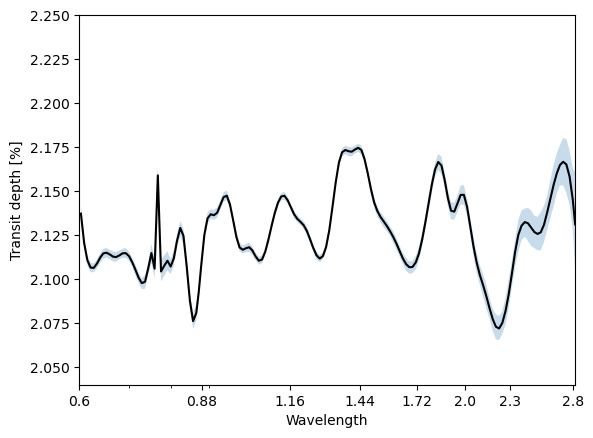

In [40]:
ax = ts.plot_transmission_spectrum()
ax.set_xscale('log')
setp(ax, ylim=(2.04, 2.25))
xticks = [0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]
ax.set_xticks(xticks, labels=xticks);

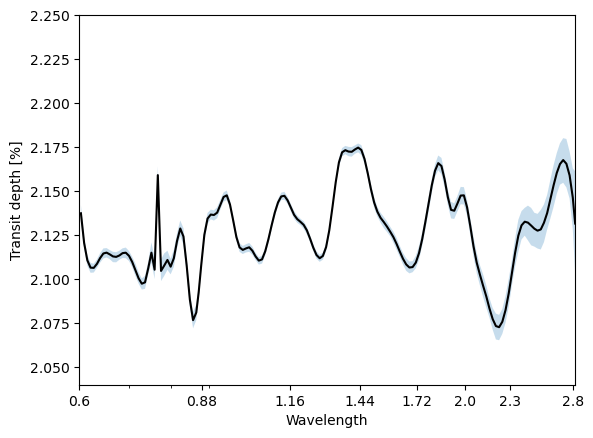

In [50]:
ax = ts.plot_transmission_spectrum()
ax.set_xscale('log')
setp(ax, ylim=(2.04, 2.25))
xticks = [0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]
ax.set_xticks(xticks, labels=xticks);

In [94]:
ts.sample(5000, thin=100, repeats=3, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/5000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/5000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/5000 [00:00<?, ?it/s]

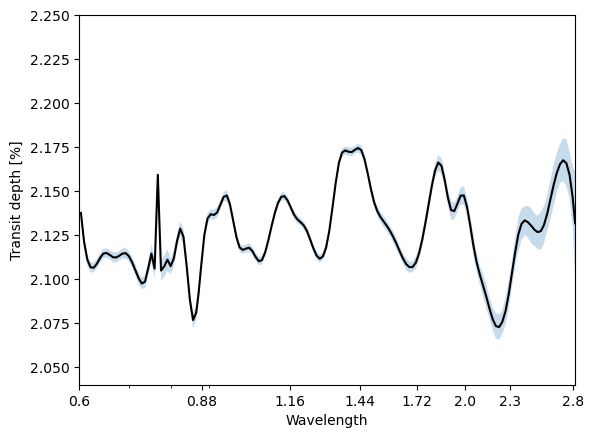

In [96]:
ax = ts.plot_transmission_spectrum()
ax.set_xscale('log')
setp(ax, ylim=(2.04, 2.25))
xticks = [0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]
ax.set_xticks(xticks, labels=xticks);

In [51]:
df = ts._tsa.posterior_samples()

In [52]:
ldc = df.iloc[:,ts._tsa._sl_ld]

In [53]:
ld1m = median(ldc.values[:,::2], 0)
ld1e = ldc.values[:,::2].std(0)
ld2m = median(ldc.values[:,1::2], 0)
ld2e = ldc.values[:,1::2].std(0)

In [54]:
ldc.shape

(2500, 20)

In [55]:
ldc = ts._tsa._eval_ldc(df.values)

In [56]:
ld1p = percentile(ldc[:,:,0], [50, 16, 84], axis=0)
ld2p = percentile(ldc[:,:,1], [50, 16, 84], axis=0)

<ErrorbarContainer object of 3 artists>

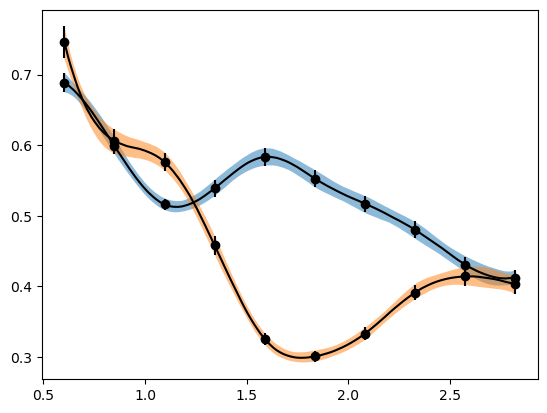

In [57]:
fill_between(ts._tsa.wavelength, ld1p[1], ld1p[2], alpha=0.5)
plot(ts._tsa.wavelength, ld1p[0], 'k')

fill_between(ts._tsa.wavelength, ld2p[1], ld2p[2], alpha=0.5)
plot(ts._tsa.wavelength, ld2p[0], 'k')

errorbar(ts._tsa.ld_knots, ld1m, ld1e, fmt='ok')
errorbar(ts._tsa.ld_knots, ld2m, ld2e, fmt='ok')

In [72]:
ldp1 = array([[p.prior.mean, p.prior.std] for p in ts.ps[ts._tsa._sl_ld][::2]])
ldp2 = array([[p.prior.mean, p.prior.std] for p in ts.ps[ts._tsa._sl_ld][1::2]])

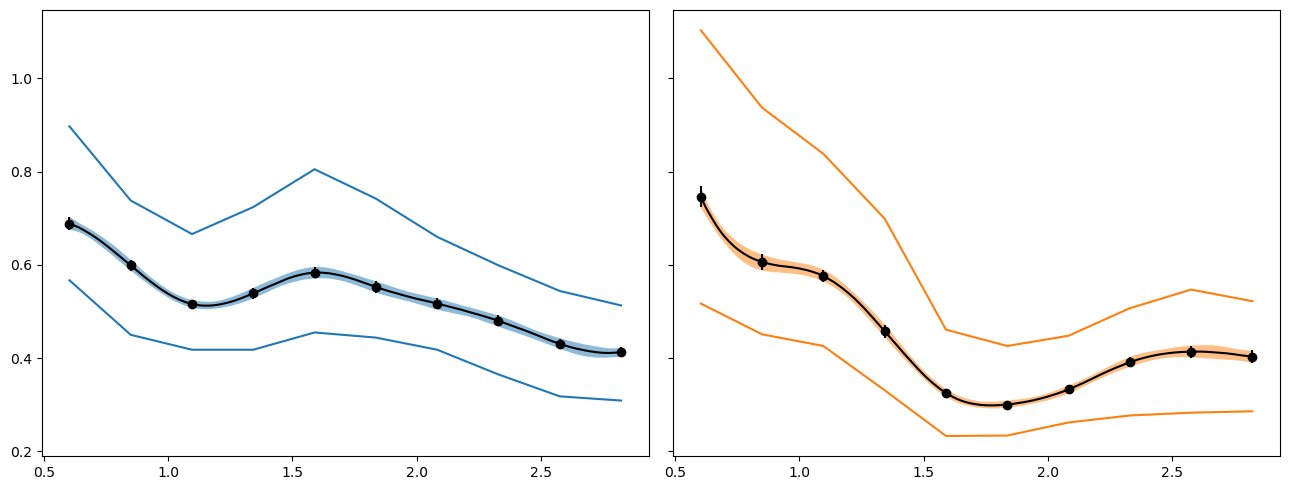

In [92]:
fig, axs = subplots(1, 2, figsize=(13,5), sharey='all')

axs[0].fill_between(ts._tsa.wavelength, ld1p[1], ld1p[2], alpha=0.5)
axs[0].plot(ts._tsa.wavelength, ld1p[0], 'k')
axs[0].errorbar(ts._tsa.ld_knots, ld1m, ld1e, fmt='ok')
axs[0].plot(ts._tsa.ld_knots, ldp1[:,0] + ldp1[:,1], '-', c='C0')
axs[0].plot(ts._tsa.ld_knots, ldp1[:,0] - ldp1[:,1], '-', c='C0')

axs[1].fill_between(ts._tsa.wavelength, ld2p[1], ld2p[2], alpha=0.5, fc='C1')
axs[1].plot(ts._tsa.wavelength, ld2p[0], 'k')
axs[1].plot(ts._tsa.ld_knots, ldp2[:,0] + ldp2[:,1], '-', c='C1')
axs[1].plot(ts._tsa.ld_knots, ldp2[:,0] - ldp2[:,1], '-', c='C1')
axs[1].errorbar(ts._tsa.ld_knots, ld2m, ld2e, fmt='ok')
fig.tight_layout()